In [1]:
!pwd


/workspace/XCache


In [45]:
from elasticsearch import Elasticsearch
from elasticsearch.helpers import scan
import pandas as pd

start_date = '2018-08-01 00:00:00'
end_date = '2018-09-01 00:00:00'
#start_date = '2018-08-01 00:00:00'
#end_date = '2018-09-01 00:00:00'
#site = 'LRZ-LMU'
#site = 'DESY-HH'
site = 'MPPMU'

es = Elasticsearch(['atlas-kibana.mwt2.org:9200'], timeout=60)
indices = "traces"

print("start:", start_date, "end:", end_date)
start = int(pd.Timestamp(start_date).timestamp())
end = int(pd.Timestamp(end_date).timestamp())

#kind = 'prod'
kind = 'analy'

my_query = {
    "_source": ["time_start", "time_end", "site", "event", "scope", "filename", "filesize"],
    'query': {
        'bool': {
            'must': [
                {'range': {'time_start': {'gte': start, 'lt': end}}},
                {'exists': {"field": "filename"}},
                {'wildcard': {'site': site + '*'}},
                # {'wildcard': {'filename': 'EVNT*'}},
                #{'wildcard': {'event': 'get_sm*'}},
                #{'term': {'event': 'get_sm'}},
                {'term': {'event': 'get_sm_a'}},
                # {'term': {'event': 'download'}},
            ]
        }
    }
}

dataset = 'AUG'

scroll = scan(client=es, index=indices, query=my_query)
count = 0
requests = []
for res in scroll:
    r = res['_source']
    requests.append([r['scope'] + ':' + r['filename'], r['filesize'], r['time_start']])

    if not count % 100000:
        print(count)
        print(res)
    count = count + 1

all_accesses = pd.DataFrame(requests).sort_values(2)
all_accesses.columns = ['filename', 'filesize', 'transfer_start']
all_accesses.set_index('filename', drop=True, inplace=True)
all_accesses.to_hdf(site + '_' + kind + '_' + dataset + '.h5', key=site, mode='w', complevel=1)

start: 2018-08-01 00:00:00 end: 2018-09-01 00:00:00
0
{'_index': 'traces-2018-08-17', '_id': '050d08675ad245dcb53ada812b5049c2', '_score': None, '_type': 'docs', 'sort': [74], '_source': {'filesize': 3761456, 'filename': 'EVNT.11335804._073069.pool.root.1', 'scope': 'mc15_13TeV', 'site': 'MPPMU_DATADISK', 'time_end': 1534521629.627758, 'event': 'get_sm_a', 'time_start': 1534521469.480716}}
100000
{'_index': 'traces-2018-08-17', '_id': '0686ef802d4e4e6c8cdb1e3702400a5d', '_score': None, '_type': 'docs', 'sort': [657795], '_source': {'filesize': 4068885, 'filename': 'EVNT.11335804._087768.pool.root.1', 'scope': 'mc15_13TeV', 'site': 'MPPMU_DATADISK', 'time_end': 1534532152.363762, 'event': 'get_sm_a', 'time_start': 1534532020.620711}}
200000
{'_index': 'traces-2018-08-14', '_id': '85c034452a544be9bcb8a8933ca79592', '_score': None, '_type': 'docs', 'sort': [1047854], '_source': {'filesize': 1823012305, 'filename': 'DAOD_FTAG1.12133022._000327.pool.root.1', 'scope': 'mc16_13TeV', 'site': '

## Access Histos ##

In [3]:
!pwd

/workspace/XCache


LRZ-LMU AUG prod 323247
      site month  kind   files  unique files  total size [PB]  \
0  LRZ-LMU   AUG  prod  323247        177722         0.544677   

   avg. filesize [GB]  
0             1.76687  
                 total  unique  avgFSize  inf. cache hit rate    uniqueFSize  \
EVNT             99769   22484  0.252505             0.774639    5677.331839   
HITS             42533   13378  2.209623             0.685468   29560.334675   
data18_13TeV     30416   16167  3.100179             0.468471   50120.600181   
DAOD_TRUTH1        355     212  8.412264             0.402817    1783.399899   
AOD             150144   97127  2.351487             0.353108  228392.870000   
log               1421    1222  0.011230             0.140042      13.723130   
DESDM_ALLCELLS    3328    2867  0.640930             0.138522    1837.546768   
TXT              11172   10405  0.031476             0.068654     327.505081   
RDO                142     136  6.989167             0.042254     950.526644 

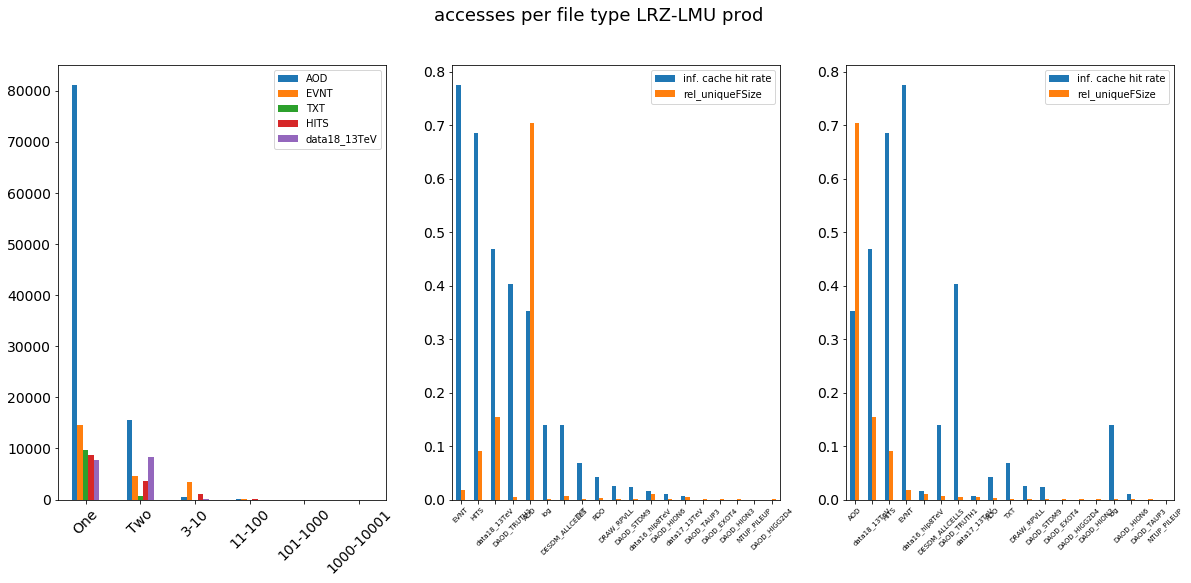

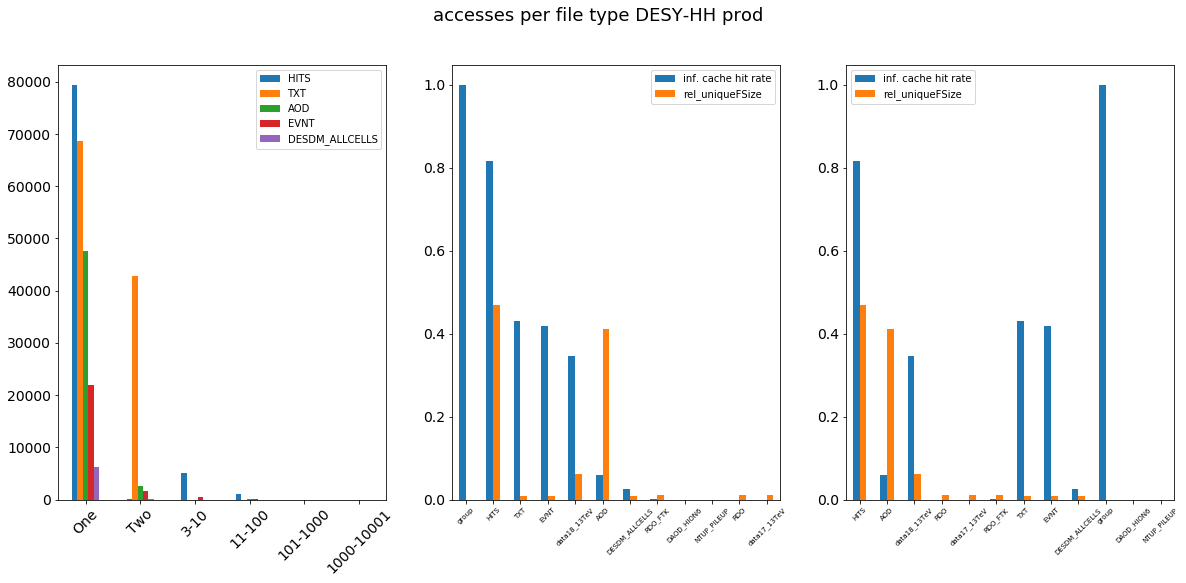

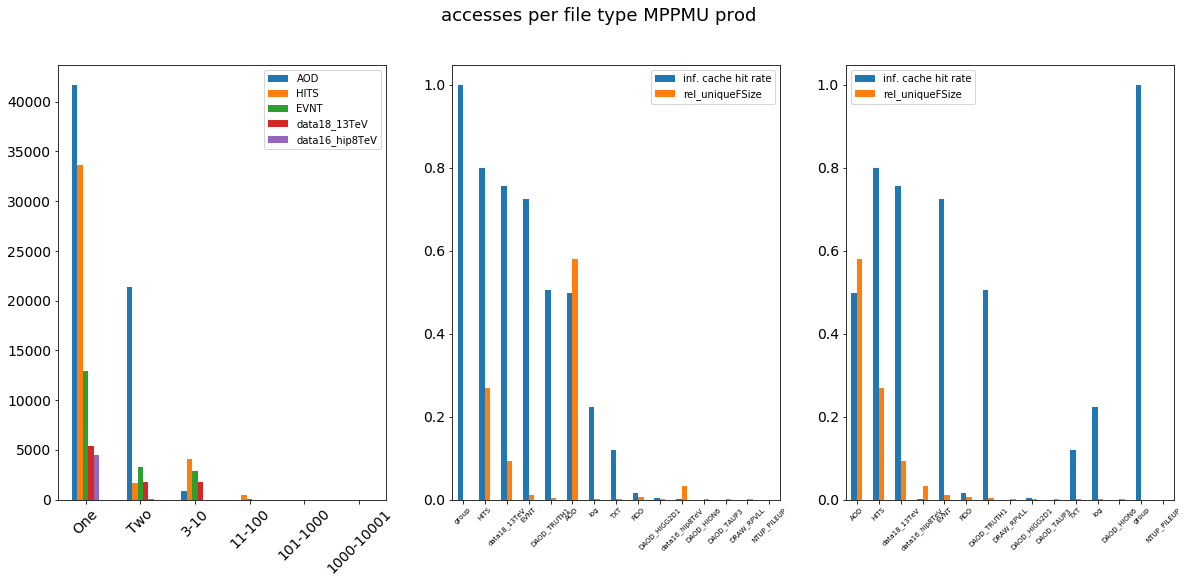

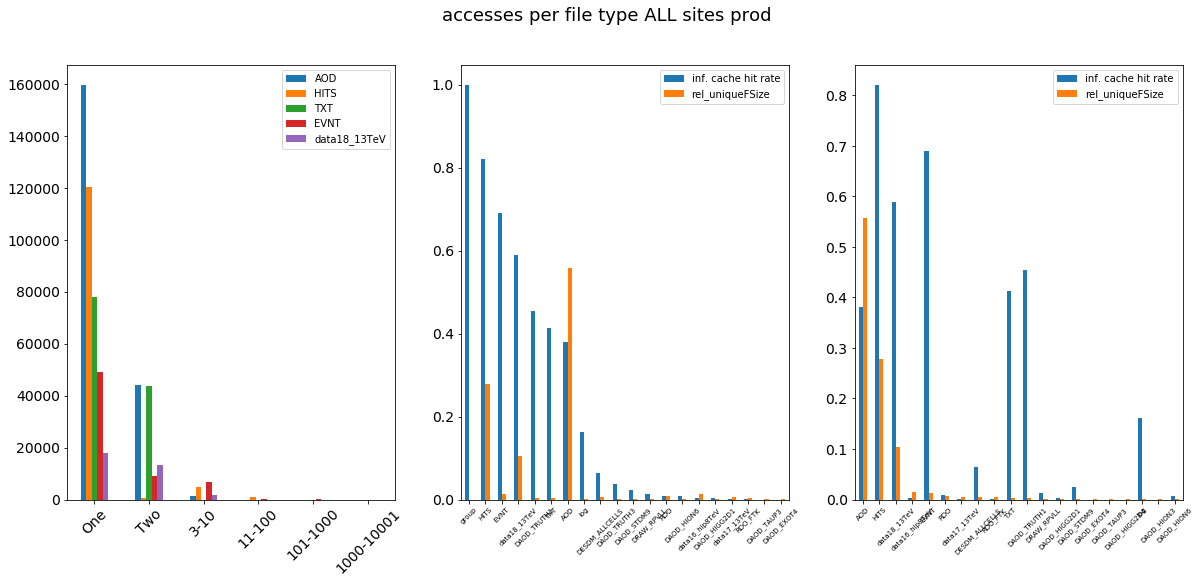

In [49]:
#GD prod stuff
# input files e.g. ../data/AUG/LRZ-LMU_prod_AUG.h5

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from cache import load_data

matplotlib.rc('xtick', labelsize=14)
matplotlib.rc('ytick', labelsize=14)

step = 10000

MB = 1024 * 1024
GB = 1024 * MB
TB = 1024 * GB
PB = 1024 * TB

#sites = ['MWT2', 'AGLT2', 'NET2', 'SWT2', 'BNL']  # , 'OU_OSCER',  'UTA_SWT2',
sites = ['LRZ-LMU','DESY-HH','MPPMU']
#sites = ['LRZ-LMU']
#sites = ['DESY-HH']
filetypes = []

periods = ['AUG']  # must be listed in order
kinds = ['prod']  # prod
#kinds = ['analy']  # 




title = ','.join(sites)

bs = [1, 2, 10, 100, 1000, 10000, 100000]
sites_data = []


def get_type(s):
    f = s.split(":")[1]
    return f.split('.')[0]


for site in sites:
    site_data = load_data([site], periods, kinds)

    # get filetypes
    fts = []
    accpft = []
    totalacc = []
    dt = site_data.groupby(by=get_type)
    for name, group in dt:
        # print(name)  # , group)
        grouped = group.groupby('filename')
        gc = grouped.size().sort_values(ascending=False)  # series
        count, division = np.histogram(gc, bins=bs)
        # print('frequencies:')
        # print(division)
        # print(count)
        totalacc.append([group.shape[0], group.index.unique().shape[0], group.filesize.mean()/GB])
        fts.append(name)
        accpft.append(count)

    accdf = pd.DataFrame(accpft, index=fts, columns=['One', 'Two', '3-10', '11-100',
                                                     '101-1000', '1000-10001']).sort_values("One", ascending=False)

    totdf = pd.DataFrame(totalacc, index=fts, columns=['total', 'unique','avgFSize'])
    #GD > 100 accesses
    totdf = totdf[totdf.total>100]
    totdf['inf. cache hit rate'] = (totdf.total - totdf.unique) / totdf.total
    totdf['uniqueFSize'] = totdf.unique * totdf.avgFSize
    totdf['rel_uniqueFSize']=totdf.uniqueFSize/totdf.uniqueFSize.sum()
    totdf.sort_values('inf. cache hit rate', ascending=False, inplace=True)
    print(totdf)
    
    print('Sum Unique Filesize :', totdf.uniqueFSize.sum())
    accdf = accdf[0:5]
    print(accdf)

    # put together in a stacked plot.
    fig, ax = plt.subplots(1, 3, figsize=(20, 8))
    title = 'accesses per file type ' + site + " " + kinds[0]
    fig.suptitle(title, fontsize=18)
    accdf.transpose().plot(ax=ax[0], kind='bar', stacked=False, logy=False, rot=45)

    totdf2 = totdf.drop(columns=["total", "unique","uniqueFSize",'avgFSize'])
    ax[1].tick_params(axis='x', which='major', labelsize=7)
    #totdf2['inf. cache hit rate'].plot(ax=ax[1], kind='bar', rot=45)
    nshow=min(20,len(totdf2))
    totdf2[:nshow].plot(ax=ax[1], kind='bar', rot=45)
    totdf2.sort_values('rel_uniqueFSize', ascending=False, inplace=True)
    #print(totdf2)
    ax[2].tick_params(axis='x', which='major', labelsize=7)
    totdf2[:nshow].plot(ax=ax[2], kind='bar', rot=45)
    

    fig.savefig(title.replace(' ', '_') + '.png')

    sites_data.append(site_data)
    print('----------------------------')

all_data = pd.concat(sites_data)

#print(all_data.head())
all_data = all_data.sort_values('transfer_start')

print('---------- Fully merged -----------')
print(all_data.shape[0], 'files\t\t', all_data.index.unique().shape[0], 'unique files')
print(all_data.filesize.sum() / PB, "PB")
print(all_data.filesize.mean() / GB, "GB avg. file size")

fts = []
accpft = []
totalacc = []
dt = all_data.groupby(by=get_type)
for name, group in dt:
    # print(name)  # , group)
    #print (name, group.filesize.mean())
    grouped = group.groupby('filename')
    gc = grouped.size().sort_values(ascending=False)  # series
    count, division = np.histogram(gc, bins=bs)
    # print('frequencies:')
    # print(division)
    # print(count)
    fts.append(name)
    accpft.append(count)
    totalacc.append([group.shape[0], group.index.unique().shape[0], group.filesize.mean()/GB ])

accdf = pd.DataFrame(accpft, index=fts, columns=['One', 'Two', '3-10', '11-100',
                                                 '101-1000', '1000-10001']).sort_values("One", ascending=False)

accdf = accdf[0:5]
print(accdf)

totdf = pd.DataFrame(totalacc, index=fts, columns=['total', 'unique','avgFSize'])
#GD > 100 accesses
totdf = totdf[totdf.total>100]
totdf['inf. cache hit rate'] = (totdf.total - totdf.unique) / totdf.total
totdf['uniqueFSize'] = totdf.unique * totdf.avgFSize
totdf['rel_uniqueFSize']=totdf.uniqueFSize/totdf.uniqueFSize.sum()
totdf.sort_values('inf. cache hit rate', ascending=False, inplace=True)
print(totdf)


# put together in a stacked plot.
fig, ax = plt.subplots(1, 3, figsize=(20, 8))
title = 'accesses per file type ALL sites' + " " + kinds[0]
fig.suptitle(title, fontsize=18)
accdf.transpose().plot(ax=ax[0], kind='bar', stacked=False, logy=False, rot=45)

totdf2 = totdf.drop(columns=["total", "unique","uniqueFSize",'avgFSize'])
ax[1].tick_params(axis='x', which='major', labelsize=7)
#totdf2['inf. cache hit rate'].plot(ax=ax[1], kind='bar', rot=45)
nshow=min(20,len(totdf2))
totdf2[:nshow].plot(ax=ax[1], kind='bar', rot=45)
totdf2.sort_values('rel_uniqueFSize', ascending=False, inplace=True)
#print(totdf2)
ax[2].tick_params(axis='x', which='major', labelsize=7)
totdf2[:nshow].plot(ax=ax[2], kind='bar', rot=45)



fig.savefig(title.replace(' ', '_') + '.png')

In [41]:
totdf.index

Index(['group', 'HITS', 'EVNT', 'data18_13TeV', 'DAOD_TRUTH1', 'TXT', 'AOD',
       'log', 'DESDM_ALLCELLS', 'DAOD_TRUTH3', 'DAOD_STDM9', 'DRAW_RPVLL',
       'RDO', 'DAOD_HION6', 'data16_hip8TeV', 'DAOD_HIGG2D1', 'data17_13TeV',
       'RDO_FTK', 'DAOD_HION3', 'DAOD_EXOT4', 'data15_13TeV', 'DAOD_HIGG2D4',
       'DAOD_SUSY2', 'DAOD_EXOT3', 'NTUP_PILEUP', 'DAOD_HIGG5D1', 'DAOD_RPVLL',
       'DAOD_TAUP3', 'DRAW_EGZ', 'DESDM_EXOTHIP', 'DAOD_HIGG8D1'],
      dtype='object')

LRZ-LMU AUG analy 796057
      site month   kind   files  unique files  total size [PB]  \
0  LRZ-LMU   AUG  analy  796057        493828          0.48894   

   avg. filesize [GB]  
0            0.644037  
               total  unique  avgFSize  inf. cache hit rate   uniqueFSize  \
DAOD_STDM7       983      60  3.910875             0.938962    234.652471   
DAOD_EXOT4      8470     790  1.256993             0.906730    993.024857   
DAOD_SUSY18     2985     561  1.178127             0.812060    660.929399   
DAOD_MUON1      6806    1342  2.110062             0.802821   2831.703424   
DAOD_JETM4      3051     643  1.439730             0.789249    925.746525   
DAOD_EXOT2      6750    1464  1.436886             0.783111   2103.601097   
DAOD_TRUTH3      547     125  2.200285             0.771481    275.035589   
DAOD_EGAM3      2389     598  0.160306             0.749686     95.863074   
DAOD_EGAM2      6744    1705  0.180569             0.747183    307.869528   
DAOD_EGAM1     26782    

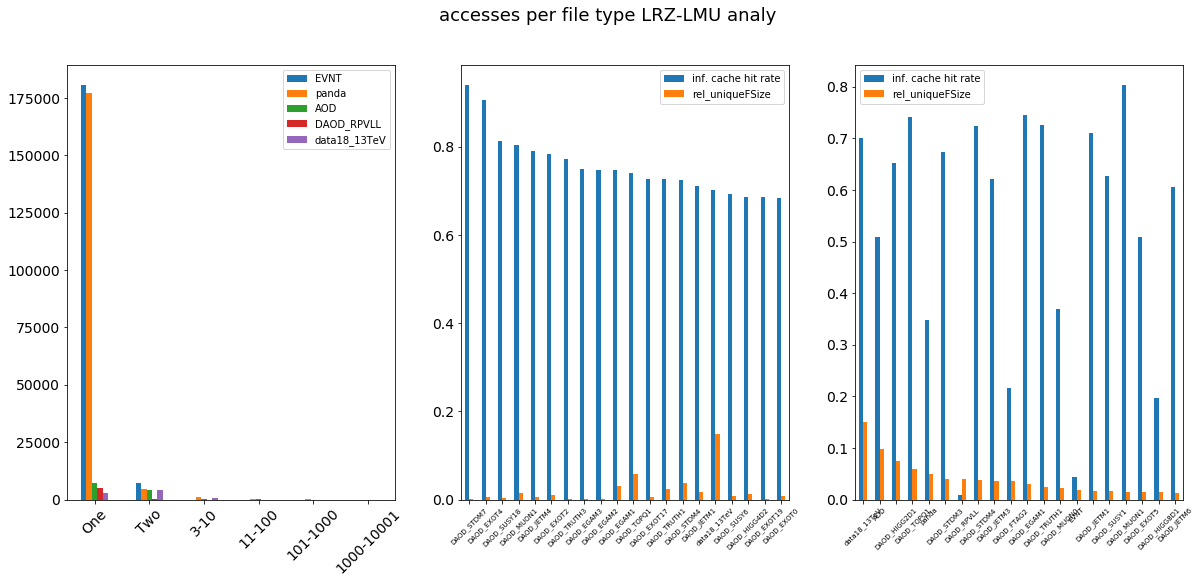

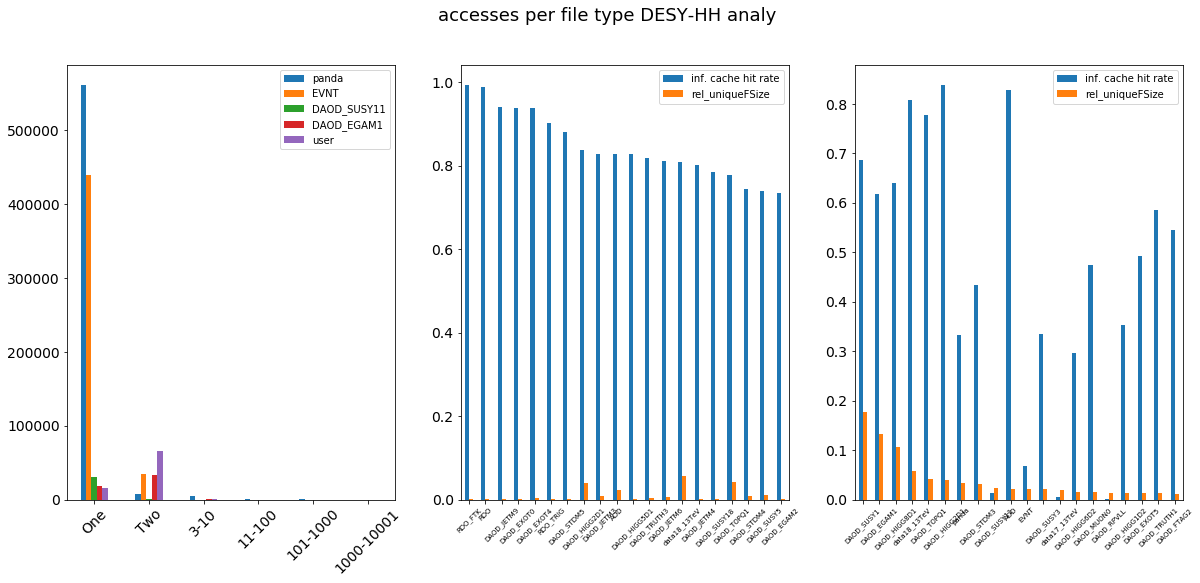

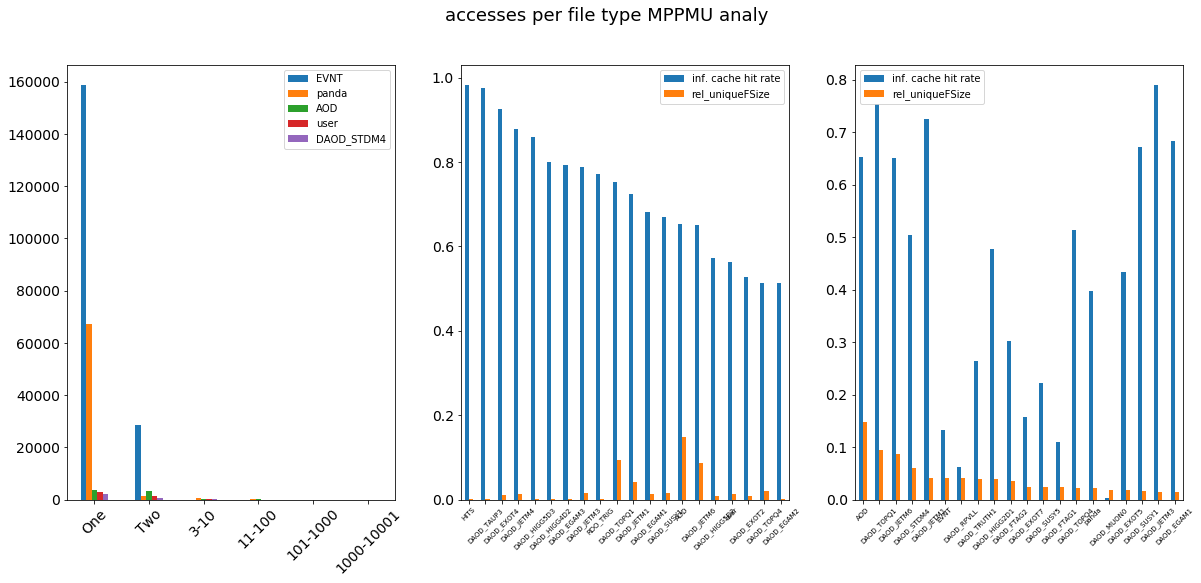

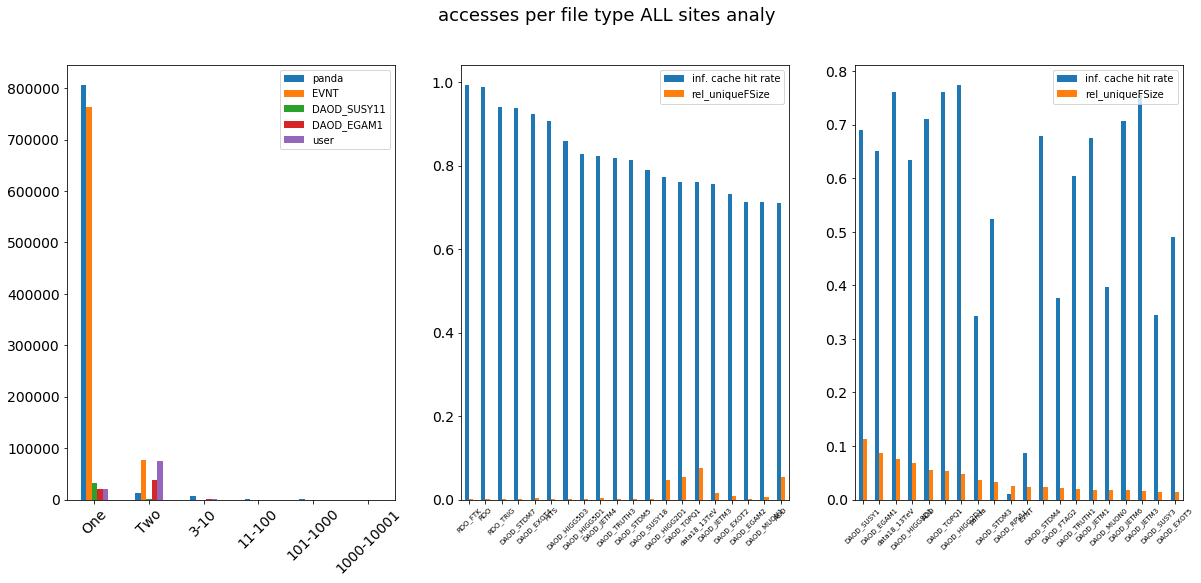

In [50]:
#GD
# input files e.g. ../data/AUG/LRZ-LMU_prod_AUG.h5

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from cache import load_data

matplotlib.rc('xtick', labelsize=14)
matplotlib.rc('ytick', labelsize=14)

step = 10000

MB = 1024 * 1024
GB = 1024 * MB
TB = 1024 * GB
PB = 1024 * TB

#sites = ['MWT2', 'AGLT2', 'NET2', 'SWT2', 'BNL']  # , 'OU_OSCER',  'UTA_SWT2',
sites = ['LRZ-LMU','DESY-HH','MPPMU']
#sites = ['LRZ-LMU']
#sites = ['DESY-HH']
filetypes = []

periods = ['AUG']  # must be listed in order
#kinds = ['prod']  # prod
kinds = ['analy']  # 




title = ','.join(sites)

bs = [1, 2, 10, 100, 1000, 10000, 100000]
sites_data = []


def get_type(s):
    f = s.split(":")[1]
    return f.split('.')[0]


for site in sites:
    site_data = load_data([site], periods, kinds)

    # get filetypes
    fts = []
    accpft = []
    totalacc = []
    dt = site_data.groupby(by=get_type)
    for name, group in dt:
        # print(name)  # , group)
        grouped = group.groupby('filename')
        gc = grouped.size().sort_values(ascending=False)  # series
        count, division = np.histogram(gc, bins=bs)
        # print('frequencies:')
        # print(division)
        # print(count)
        totalacc.append([group.shape[0], group.index.unique().shape[0], group.filesize.mean()/GB])
        fts.append(name)
        accpft.append(count)

    accdf = pd.DataFrame(accpft, index=fts, columns=['One', 'Two', '3-10', '11-100',
                                                     '101-1000', '1000-10001']).sort_values("One", ascending=False)

    totdf = pd.DataFrame(totalacc, index=fts, columns=['total', 'unique','avgFSize'])
    #GD > 100 accesses
    totdf = totdf[totdf.total>100]
    totdf['inf. cache hit rate'] = (totdf.total - totdf.unique) / totdf.total
    totdf['uniqueFSize'] = totdf.unique * totdf.avgFSize
    totdf['rel_uniqueFSize']=totdf.uniqueFSize/totdf.uniqueFSize.sum()
    totdf.sort_values('inf. cache hit rate', ascending=False, inplace=True)
    print(totdf)
    
    print('Sum Unique Filesize :', totdf.uniqueFSize.sum())
    accdf = accdf[0:5]
    print(accdf)

    # put together in a stacked plot.
    fig, ax = plt.subplots(1, 3, figsize=(20, 8))
    title = 'accesses per file type ' + site + " " + kinds[0]
    fig.suptitle(title, fontsize=18)
    accdf.transpose().plot(ax=ax[0], kind='bar', stacked=False, logy=False, rot=45)

    totdf2 = totdf.drop(columns=["total", "unique","uniqueFSize",'avgFSize'])
    ax[1].tick_params(axis='x', which='major', labelsize=7)
    #totdf2['inf. cache hit rate'].plot(ax=ax[1], kind='bar', rot=45)
    nshow=min(20,len(totdf2))
    totdf2[:nshow].plot(ax=ax[1], kind='bar', rot=45)
    totdf2.sort_values('rel_uniqueFSize', ascending=False, inplace=True)
    #print(totdf2)
    ax[2].tick_params(axis='x', which='major', labelsize=7)
    totdf2[:nshow].plot(ax=ax[2], kind='bar', rot=45)
    

    fig.savefig(title.replace(' ', '_') + '.png')

    sites_data.append(site_data)
    print('----------------------------')

all_data = pd.concat(sites_data)

#print(all_data.head())
all_data = all_data.sort_values('transfer_start')

print('---------- Fully merged -----------')
print(all_data.shape[0], 'files\t\t', all_data.index.unique().shape[0], 'unique files')
print(all_data.filesize.sum() / PB, "PB")
print(all_data.filesize.mean() / GB, "GB avg. file size")

fts = []
accpft = []
totalacc = []
dt = all_data.groupby(by=get_type)
for name, group in dt:
    # print(name)  # , group)
    #print (name, group.filesize.mean())
    grouped = group.groupby('filename')
    gc = grouped.size().sort_values(ascending=False)  # series
    count, division = np.histogram(gc, bins=bs)
    # print('frequencies:')
    # print(division)
    # print(count)
    fts.append(name)
    accpft.append(count)
    totalacc.append([group.shape[0], group.index.unique().shape[0], group.filesize.mean()/GB ])

accdf = pd.DataFrame(accpft, index=fts, columns=['One', 'Two', '3-10', '11-100',
                                                 '101-1000', '1000-10001']).sort_values("One", ascending=False)

accdf = accdf[0:5]
print(accdf)

totdf = pd.DataFrame(totalacc, index=fts, columns=['total', 'unique','avgFSize'])
#GD > 100 accesses
totdf = totdf[totdf.total>100]
totdf['inf. cache hit rate'] = (totdf.total - totdf.unique) / totdf.total
totdf['uniqueFSize'] = totdf.unique * totdf.avgFSize
totdf['rel_uniqueFSize']=totdf.uniqueFSize/totdf.uniqueFSize.sum()
totdf.sort_values('inf. cache hit rate', ascending=False, inplace=True)
print(totdf)


# put together in a stacked plot.
fig, ax = plt.subplots(1, 3, figsize=(20, 8))
title = 'accesses per file type ALL sites' + " " + kinds[0]
fig.suptitle(title, fontsize=18)
accdf.transpose().plot(ax=ax[0], kind='bar', stacked=False, logy=False, rot=45)

totdf2 = totdf.drop(columns=["total", "unique","uniqueFSize",'avgFSize'])
ax[1].tick_params(axis='x', which='major', labelsize=7)
#totdf2['inf. cache hit rate'].plot(ax=ax[1], kind='bar', rot=45)
nshow=min(20,len(totdf2))
totdf2[:nshow].plot(ax=ax[1], kind='bar', rot=45)
totdf2.sort_values('rel_uniqueFSize', ascending=False, inplace=True)
#print(totdf2)
ax[2].tick_params(axis='x', which='major', labelsize=7)
totdf2[:nshow].plot(ax=ax[2], kind='bar', rot=45)



fig.savefig(title.replace(' ', '_') + '.png')




In [43]:
totdf.index

Index(['RDO_FTK', 'RDO', 'DAOD_JETM9', 'DAOD_EXOT0', 'DAOD_EXOT4', 'RDO_TRIG',
       'DAOD_STDM5', 'DAOD_HIGG2D1', 'DAOD_JETM3', 'AOD', 'DAOD_HIGG5D1',
       'DAOD_TRUTH3', 'DAOD_JETM6', 'data18_13TeV', 'DAOD_JETM4',
       'DAOD_SUSY18', 'DAOD_TOPQ1', 'DAOD_STDM4', 'DAOD_SUSY5', 'DAOD_EGAM2',
       'DAOD_EXOT2', 'DAOD_JETM5', 'DAOD_SUSY1', 'TXT', 'DAOD_SUSY2',
       'DAOD_HIGG4D6', 'DAOD_HIGG8D1', 'DAOD_SUSY6', 'DAOD_EGAM1',
       'DAOD_EXOT6', 'DAOD_JETM1', 'DAOD_EXOT9', 'user', 'DAOD_FTAG1',
       'DAOD_HIGG4D3', 'DAOD_TRUTH1', 'DAOD_EXOT3', 'DAOD_EGAM4', 'DAOD_FTAG2',
       'DAOD_BPHY8', 'DAOD_EXOT5', 'DAOD_JETM11', 'DAOD_HIGG3D1', 'DAOD_EXOT8',
       'DAOD_MUON0', 'DAOD_MUON1', 'DAOD_SUSY10', 'DAOD_EGAM3', 'DAOD_STDM3',
       'DAOD_SUSY4', 'DAOD_HIGG5D2', 'DAOD_HIGG4D1', 'DAOD_EXOT12',
       'DAOD_HIGG6D1', 'DAOD_HIGG1D2', 'DAOD_HIGG4D2', 'DAOD_SUSY3', 'panda',
       'DAOD_BPHY5', 'DAOD_TAUP3', 'DAOD_EXOT17', 'DAOD_HIGG6D2', 'DAOD_TOPQ4',
       'DAOD_SUSY8', 'DAOD_STDM

In [17]:
%matplotlib inline
fig = plt.figure()
totdf.plot(ax=ax[1], kind='bar', rot=45)
fig.show()


/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


<Figure size 432x288 with 0 Axes>

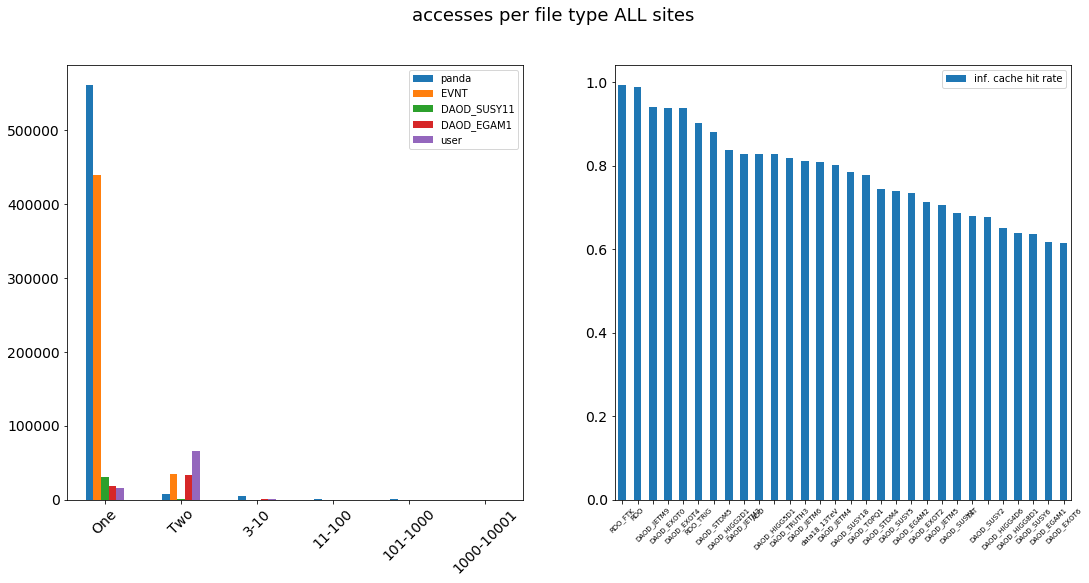

In [24]:
# put together in a stacked plot.
fig, ax = plt.subplots(1, 2, figsize=(18, 8))
title = 'accesses per file type ALL sites'
fig.suptitle(title, fontsize=18)
accdf.transpose().plot(ax=ax[0], kind='bar', stacked=False, logy=False, rot=45)

#totdf = totdf.drop(columns=["total", "unique",'avgFSize'])
ax[1].tick_params(axis='x', which='major', labelsize=7)
totdf[:30].plot(ax=ax[1], kind='bar', rot=45)


In [25]:
len(totdf)

89